In [1]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
#import Tensorflow namespaces

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import os
from PIL import Image

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
# Read and preprocess images
# change accordingly with how many images you have total train + test
image_size = 100
nr_train_images = 900
nr_test_images = 100
can_train_images = []
can_test_images = []
back_train_images = []
back_test_images = []
y_can_train = []
y_back_train = []
y_can_test = []
y_back_test =[]

# read train_images 1
path = './Datasets/kaggle/All_bottles'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    can_train_images.append(im)
    y_can_train.append(1)
    
    
# read test_images 1

path = './Datasets/kaggle/All_bottles'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f))
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    can_test_images.append(im)
    y_can_test.append(1)
    
    
# read background train_images 1
path = './Datasets/CBCL streetscenes'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_train_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    back_train_images.append(im)
    y_back_train.append(0)
    

# read background test_images 1
path = './Datasets/CBCL streetscenes'
valid_images = [".jpg",".gif",".png"]

for f in os.listdir(path)[:nr_test_images]:
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    im = imread(os.path.join(path,f)) 
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    back_test_images.append(im)
    y_back_test.append(0)
    

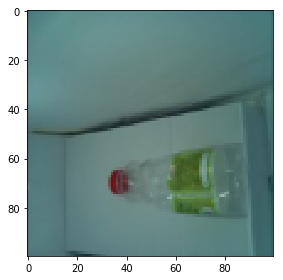

In [4]:
imshow(can_train_images[0])

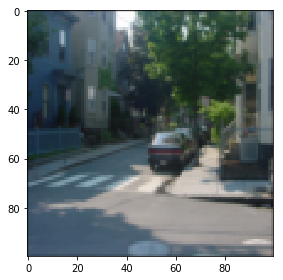

In [5]:
imshow(back_train_images[0])

In [6]:
# Create a training set and test set. Make sure the datasets are randomized. 
from sklearn.utils import shuffle
import random

X_train = can_train_images + back_train_images
X_test = can_test_images + back_test_images
y_train = y_can_train + y_back_train
y_test = y_can_test + y_back_test

c = list(zip(X_train, y_train))

random.shuffle(c)

X_train, y_train = zip(*c)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800, 100, 100, 3)
(200, 100, 100, 3)
(1800,)
(200,)


In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train=to_categorical(y_train,num_classes=2)

In [9]:
class_weight = {0:1, 1:1, 2:1}
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max')


In [9]:
# Neural network
#-----------------------------------------------
#-----------------------------------------------
batch_size = 128 # 
epochs = 50 # 
steps = None
#-----------------------------------------------
#-----------------------------------------------
num_classes = 2
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3)# 3 duidt het aantal kleurkanalen aan

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Model
model = Sequential()
#-----------------------------------------------
#-----------------------------------------------
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape)) 
#-----------------------------------------------
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.3)) # Value between 0 and 1 
# model.add(BatchNormalisation())# Altijd achter de dropout
#-----------------------------------------------
model.add(Conv2D(100, (3, 3), activation='relu')) 
#-----------------------------------------------
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.3)) # Value between 0 and 1 
#-----------------------------------------------
#-----------------------------------------------
model.add(Flatten()) # Zeer belangrijk: van 2D naar 1D
model.add(Dense(50, activation='relu')) 
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.3)) # Value between 0 and 1 
#-----------------------------------------------
#-----------------------------------------------
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('NN_bottles.h5', verbose=1, save_best_only=True)


# Trainen van het CNN
history = model.fit(X_train, y_train,batch_size=batch_size, callbacks=[earlystopper, mc],
                    class_weight=class_weight, epochs=epochs,  validation_split=0.2, verbose=1, 
                    steps_per_epoch = steps)

Train on 1440 samples, validate on 360 samples
Epoch 1/50
1440/1440 [==============================] - 8s 6ms/sample - loss: 0.6514 - accuracy: 0.5875 - val_loss: 0.6158 - val_accuracy: 0.7722
Epoch 2/50
1440/1440 [==============================] - 7s 5ms/sample - loss: 0.5152 - accuracy: 0.7660 - val_loss: 0.6792 - val_accuracy: 0.5389
Epoch 3/50
1440/1440 [==============================] - 7s 5ms/sample - loss: 0.3882 - accuracy: 0.8594 - val_loss: 0.5544 - val_accuracy: 0.7083
Epoch 4/50
1440/1440 [==============================] - 7s 5ms/sample - loss: 0.2734 - accuracy: 0.9080 - val_loss: 0.4644 - val_accuracy: 0.8083
Epoch 5/50
1440/1440 [==============================] - 7s 5ms/sample - loss: 0.2015 - accuracy: 0.9229 - val_loss: 0.4495 - val_accuracy: 0.7917
Epoch 6/50
1440/1440 [==============================] - 7s 5ms/sample - loss: 0.1574 - accuracy: 0.9382 - val_loss: 0.3703 - val_accuracy: 0.8583
Epoch 7/50
1440/1440 [==============================] - 7s 5ms/sample - loss:

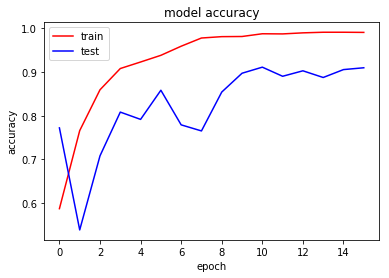

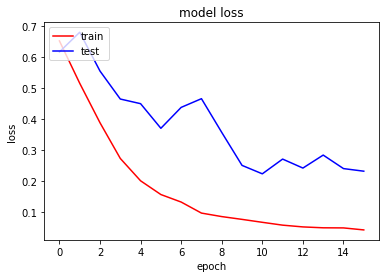

In [10]:
# Plot of the training history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# accuracy
y_pred = model.predict_classes(X_test)
print('\n')
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred)*100)



              precision    recall  f1-score   support

           0       1.00      0.83      0.91       100
           1       0.85      1.00      0.92       100

    accuracy                           0.92       200
   macro avg       0.93      0.92      0.91       200
weighted avg       0.93      0.92      0.91       200

[[ 83  17]
 [  0 100]]
91.5


In [12]:
model.save('./models/bottlesV1.tflearn')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/bottlesV1.tflearn/assets


In [4]:
#model.load('./models/blikjesV1.tflearn')
model = tf.keras.models.load_model('./models/blikjesandbackV1.tflearn')



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train=to_categorical(y_train,num_classes=2)

In [10]:
# Neural network
#-----------------------------------------------
#-----------------------------------------------
batch_size = 128 # 
epochs = 50 # 
#-----------------------------------------------
#-----------------------------------------------
num_classes = 2
img_rows, img_cols = image_size, image_size
input_shape = (img_rows, img_cols,3)# 3 duidt het aantal kleurkanalen aan

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Model
model = Sequential()
#-----------------------------------------------
#-----------------------------------------------
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape)) 
#-----------------------------------------------
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.3)) # Value between 0 and 1 
# model.add(BatchNormalisation())# Altijd achter de dropout
#-----------------------------------------------
model.add(Conv2D(100, (3, 3), activation='relu')) 
#-----------------------------------------------
#-----------------------------------------------
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.3)) # Value between 0 and 1 
#-----------------------------------------------
#-----------------------------------------------
model.add(Flatten()) # Zeer belangrijk: van 2D naar 1D
model.add(Dense(50, activation='relu')) 
#-----------------------------------------------
#-----------------------------------------------
model.add(Dropout(0.3)) # Value between 0 and 1 
#-----------------------------------------------
#-----------------------------------------------
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('NN_bottles_aug.h5', verbose=1, save_best_only=True)

# image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rotation_range = 20, zoom_range = 0.15, width_shift_range = 0.2, 
                         height_shift_range = 0.2, shear_range = 0.15, horizontal_flip = True, 
                         fill_mode = 'nearest')


# Trainen van het CNN
history_aug = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
                                  steps_per_epoch=len(X_train) // batch_size,callbacks=[earlystopper, mc],class_weight=class_weight, epochs=epochs)

Epoch 1/50
14/14 [==============================] - 13s 906ms/step - loss: 0.8391 - accuracy: 0.6014
Epoch 2/50
14/14 [==============================] - 12s 873ms/step - loss: 0.2884 - accuracy: 0.8986
Epoch 3/50
14/14 [==============================] - 12s 881ms/step - loss: 0.1302 - accuracy: 0.9548
Epoch 4/50
14/14 [==============================] - 13s 920ms/step - loss: 0.0909 - accuracy: 0.9727
Epoch 5/50
14/14 [==============================] - 12s 868ms/step - loss: 0.0576 - accuracy: 0.9836
Epoch 6/50
14/14 [==============================] - 11s 805ms/step - loss: 0.0476 - accuracy: 0.9868
Epoch 7/50
14/14 [==============================] - 12s 854ms/step - loss: 0.0439 - accuracy: 0.9922
Epoch 8/50
14/14 [==============================] - 12s 853ms/step - loss: 0.0286 - accuracy: 0.9901
Epoch 9/50
14/14 [==============================] - 13s 948ms/step - loss: 0.0353 - accuracy: 0.9902
Epoch 10/50
14/14 [==============================] - 12s 876ms/step - loss: 0.0332 - accura

KeyError: 'val_accuracy'

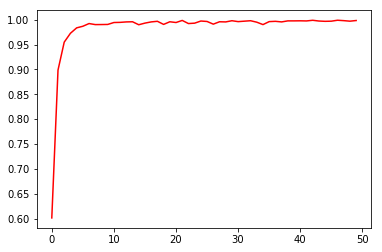

In [11]:
# Plot of the training history

# Accuray 
plt.plot(history_aug.history['accuracy'],'r')
plt.plot(history_aug.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# accuracy
y_pred = model.predict_classes(X_test)
print('\n')
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred)*100)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

[[100   0]
 [  0 100]]
100.0


In [13]:
model.save('./models/bottlesV1aug.tflearn')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/bottlesV1aug.tflearn/assets


In [2]:
model = tf.keras.models.load_model('./models/bottlesV1.tflearn')


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015AC99AF548> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000015AD8B560C8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015AD8B5D848> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000015AD8B60E48>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x0000015AD8B66D48> and <tensorflow.python.keras.layers.core.Dropout object at 0x0000015AD8B6BE08>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dropout object at 0x0000015AD8B56948> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000015AD8B560C8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Co

In [3]:
import cv2

In [4]:
model.save('bottles.h5')

In [5]:
model = tf.keras.models.load_model('bottles.h5')

In [6]:
for i in range(10):
    image=cv2.imread('D:/Documenten7/Semester5/Researchproject/research-project/Camera_research/timelapse/images-timelapse/image{0}.jpg'.format(i))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((100,100))
    p = np.expand_dims(size_image, 0)
    img = tf.cast(p, tf.float32)
    print(['can','background'][np.argmax(model.predict(img))])

background
can
can
can
can
can
background
can
can
can


In [17]:
model.summary()
for i in range(10):
    image=cv2.imread('/home/pi/Documents/research-project/Camera_research/timelapse/images-timelapse/' + 'image{0}.jpg'.format(i))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((100,100))
    p = np.expand_dims(size_image, 0)
    img = tf.cast(p, tf.float32)
    print(['can','background'][np.argmax(model.predict(img, steps=1))])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 100)       28900     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 23, 100)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 52900)            

In [20]:
image=cv2.imread('./test_images/grass.jpg')
image_from_array = Image.fromarray(image, 'RGB')
size_image = image_from_array.resize((100,100))
p = np.expand_dims(size_image, 0)
img = tf.cast(p, tf.float32)
print(['background','can'][np.argmax(model.predict(img))])

background


In [21]:
image=cv2.imread('./test_images/gras2.jpg')
image_from_array = Image.fromarray(image, 'RGB')
size_image = image_from_array.resize((100,100))
p = np.expand_dims(size_image, 0)
img = tf.cast(p, tf.float32)
print(['background','can'][np.argmax(model.predict(img))])

background


In [22]:
image=cv2.imread('./test_images/asfalt.jpg')
image_from_array = Image.fromarray(image, 'RGB')
size_image = image_from_array.resize((100,100))
p = np.expand_dims(size_image, 0)
img = tf.cast(p, tf.float32)
print(['background','can'][np.argmax(model.predict(img))])

can


In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.applications.vgg19 import VGG19
# load the model
model = VGG19()
# load an image from file
image = load_img('/home/pi/Documents/research-project/Camera_research/timelapse/images-timelapse/image5.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

Using TensorFlow backend.






574717952/574710816 [==============================] - 326s 1us/step






40960/35363 [==================================] - 0s 3us/step
water_bottle (26.29%)
